In [81]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from scipy.stats import spearmanr

In [82]:
tickers = ['KO', 'JNJ', 'MSFT', 'TSLA', 'NVDA', 'XOM', 'SPY', 'SHY']
data = yf.download(tickers, start="2020-01-01", end="2025-01-01",auto_adjust=False, group_by='column')['Adj Close']

data.ffill()

[*********************100%***********************]  8 of 8 completed


Ticker,JNJ,KO,MSFT,NVDA,SHY,SPY,TSLA,XOM
Date,,,,,,,,
2020-01-02,124.072960,46.419704,152.791107,5.971746,75.102066,299.406433,28.684000,54.131065
2020-01-03,122.636490,46.166447,150.888596,5.876163,75.164146,297.139313,29.534000,53.695885
2020-01-06,122.483528,46.149567,151.278656,5.900805,75.137550,298.272858,30.102667,54.108177
2020-01-07,123.231483,45.795033,149.899307,5.972244,75.137550,297.434174,31.270666,53.665340
2020-01-08,123.214500,45.879444,152.286942,5.983446,75.102066,299.019348,32.809334,52.856052
...,...,...,...,...,...,...,...,...
2024-12-24,142.416565,61.939281,436.929108,140.197372,79.688919,597.729492,462.279999,103.530914
2024-12-26,142.152908,61.673149,435.715790,139.907410,79.708405,597.769348,454.130005,103.618484
2024-12-27,141.635391,61.554871,428.177216,136.987869,79.727898,591.476868,431.660004,103.608757


In [83]:
# Create features

ret = data.pct_change()
ret1 = ret.shift(1)
ret2 = ret.shift(2)
ret5 =ret.shift(5)
ret10 = ret.shift(10)

mn_5 = ret.rolling(window=5).mean()
mn_10 = ret.rolling(10).mean()
mn_21 = ret.rolling(21).mean()

vol_5 = ret.rolling(5).std()
vol_21 = ret.rolling(21).std()

mom_5 = (1+ret).rolling(5).apply(lambda x: x.prod(), raw=True) - 1    # 
mom_21 = (1+ret).rolling(21).apply(lambda x: x.prod(), raw=True) - 1

mkt_r_t = ret.mean(axis=1)   # Crossectional mean across all tickers per day


label = ret.shift(-1)




In [84]:
# Put features in a df

feat_wide = {
    "r_t"     : ret,
    "r_lag1"  : ret1,
    "r_lag2"  : ret2,
    "r_lag5"  : ret5,
    "r_lag10" : ret10,
    "mean_5"  : mn_5,
    "mean_10" : mn_10,
    "mean_21" : mn_21,
    "std_5"   : vol_5,
    "std_21"  : vol_21,   
    "mom_5"   : mom_5,
    "mom_21"  : mom_21,
}


F = pd.concat(feat_wide, axis=1)   # concat features side by side, column-wise
F.head()

r_t                                                    \
Ticker           JNJ        KO      MSFT      NVDA       SHY       SPY   
Date                                                                     
2020-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-03 -0.011578 -0.005456 -0.012452 -0.016006  0.000827 -0.007572   
2020-01-06 -0.001247 -0.000366  0.002585  0.004194 -0.000354  0.003815   
2020-01-07  0.006107 -0.007682 -0.009118  0.012107  0.000000 -0.002812   
2020-01-08 -0.000138  0.001843  0.015928  0.001876 -0.000472  0.005329   

                                  r_lag1            ... mom_5     mom_21      \
Ticker          TSLA       XOM       JNJ        KO  ...  TSLA XOM    JNJ  KO   
Date                                                ...                        
2020-01-02       NaN       NaN       NaN       NaN  ...   NaN NaN    NaN NaN   
2020-01-03  0.029633 -0.008039       NaN       NaN  ...   NaN NaN    NaN NaN   
2020-01-06  0.019255  0.007678 -0.011578 -0.005456  ...   NaN NaN    NaN NaN   
2020-01-07  0.038801 -0.008184 -0.001247 -0.000366  ...   NaN NaN    NaN NaN   
2020-01-08  0.049205 -0.015080  0.006107 -0.007682  ...   NaN NaN    NaN NaN   

                                       
Ticker     MSFT NVDA SHY SPY TSLA XOM  
Date                                   
2020-01-02  NaN  NaN NaN NaN  NaN NaN  
2020-01-03  NaN  NaN NaN NaN  NaN NaN  
2020-01-06  NaN  NaN NaN NaN  NaN NaN  
2020-01-07  NaN  NaN NaN NaN  NaN NaN  
2020-01-08  NaN  NaN NaN NaN  NaN NaN  

[5 rows x 96 columns]

In [85]:
g=F.stack(level=0,future_stack=True).reset_index()
g.head()

Ticker,Date,level_1,JNJ,KO,MSFT,NVDA,SHY,SPY,TSLA,XOM
0,2020-01-02,r_t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,r_lag1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,r_lag2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-02,r_lag5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-02,r_lag10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df_long = F.stack(level=1, future_stack=True).reset_index()  # Stack second column name( Tickers) into feature column. Therefore each ticker per row. reset index so all rows have dates

df_long.tail(20)

,Date,Ticker,r_t,r_lag1,r_lag2,r_lag5,r_lag10,mean_5,mean_10,mean_21,std_5,std_21,mom_5,mom_21
10044,2024-12-27,SHY,0.000245,0.000245,0.000489,0.001102,-0.000487,0.000098,-0.000049,0.000107,0.000418,0.000700,0.000489,0.002252
10045,2024-12-27,SPY,-0.010527,0.000067,0.011115,-0.000307,-0.005153,0.003731,-0.001150,-0.000252,0.009286,0.008818,0.018619,-0.006056
10046,2024-12-27,TSLA,-0.049479,-0.017630,0.073572,-0.008997,-0.015703,-0.001105,0.004383,0.012457,0.049697,0.040262,-0.010340,0.276232
10047,2024-12-27,XOM,-0.000094,0.000846,0.000941,-0.008551,-0.000893,0.001833,-0.004849,-0.004833,0.001799,0.008491,0.009193,-0.097398
10048,2024-12-30,JNJ,-0.011789,-0.003641,-0.001851,0.006199,0.002598,-0.001550,-0.002207,-0.003802,0.006897,0.008895,-0.007822,-0.077606
10049,2024-12-30,KO,-0.006725,-0.001918,-0.004297,0.001601,-0.011278,-0.001657,-0.001716,-0.001407,0.005371,0.009105,-0.008313,-0.029948
10050,2024-12-30,MSFT,-0.013240,-0.017302,-0.002777,-0.000984,-0.005094,-0.005407,-0.005039,0.000280,0.010411,0.012354,-0.026958,0.004350
10051,2024-12-30,NVDA,0.003503,-0.020868,-0.002068,0.030762,-0.022499,0.004280,0.002559,0.000960,0.020840,0.020875,0.020713,0.015956
10052,2024-12-30,SHY,0.001467,0.000245,0.000245,0.000122,-0.000487,0.000367,0.000147,0.000148,0.000744,0.000754,0.001834,0.003112
10053,2024-12-30,SPY,-0.011412,-0.010527,0.000067,0.012011,-0.000198,-0.000954,-0.002272,-0.000651,0.009949,0.009134,-0.004957,-0.014412


In [87]:
mkt_df = mkt_r_t.rename('mkt_r_t').reset_index()  # name column mkt_r_t
df_long= df_long.merge(mkt_df,how='left', on='Date')

df_long.tail(20)

,Date,Ticker,r_t,r_lag1,r_lag2,r_lag5,r_lag10,mean_5,mean_10,mean_21,std_5,std_21,mom_5,mom_21,mkt_r_t
10044,2024-12-27,SHY,0.000245,0.000245,0.000489,0.001102,-0.000487,0.000098,-0.000049,0.000107,0.000418,0.000700,0.000489,0.002252,-0.012948
10045,2024-12-27,SPY,-0.010527,0.000067,0.011115,-0.000307,-0.005153,0.003731,-0.001150,-0.000252,0.009286,0.008818,0.018619,-0.006056,-0.012948
10046,2024-12-27,TSLA,-0.049479,-0.017630,0.073572,-0.008997,-0.015703,-0.001105,0.004383,0.012457,0.049697,0.040262,-0.010340,0.276232,-0.012948
10047,2024-12-27,XOM,-0.000094,0.000846,0.000941,-0.008551,-0.000893,0.001833,-0.004849,-0.004833,0.001799,0.008491,0.009193,-0.097398,-0.012948
10048,2024-12-30,JNJ,-0.011789,-0.003641,-0.001851,0.006199,0.002598,-0.001550,-0.002207,-0.003802,0.006897,0.008895,-0.007822,-0.077606,-0.009746
10049,2024-12-30,KO,-0.006725,-0.001918,-0.004297,0.001601,-0.011278,-0.001657,-0.001716,-0.001407,0.005371,0.009105,-0.008313,-0.029948,-0.009746
10050,2024-12-30,MSFT,-0.013240,-0.017302,-0.002777,-0.000984,-0.005094,-0.005407,-0.005039,0.000280,0.010411,0.012354,-0.026958,0.004350,-0.009746
10051,2024-12-30,NVDA,0.003503,-0.020868,-0.002068,0.030762,-0.022499,0.004280,0.002559,0.000960,0.020840,0.020875,0.020713,0.015956,-0.009746
10052,2024-12-30,SHY,0.001467,0.000245,0.000245,0.000122,-0.000487,0.000367,0.000147,0.000148,0.000744,0.000754,0.001834,0.003112,-0.009746
10053,2024-12-30,SPY,-0.011412,-0.010527,0.000067,0.012011,-0.000198,-0.000954,-0.002272,-0.000651,0.009949,0.009134,-0.004957,-0.014412,-0.009746


In [88]:
df_long["dow"] = pd.to_datetime(df_long["Date"]).dt.dayofweek  # Set day of week, 0-6 represents monday-sunday

In [89]:
label.head(10)

Ticker,JNJ,KO,MSFT,NVDA,SHY,SPY,TSLA,XOM
Date,,,,,,,,
2020-01-02,-0.011578,-0.005456,-0.012452,-0.016006,0.000827,-0.007572,0.029633,-0.008039
2020-01-03,-0.001247,-0.000366,0.002585,0.004194,-0.000354,0.003815,0.019255,0.007678
2020-01-06,0.006107,-0.007682,-0.009118,0.012107,0.000000,-0.002812,0.038801,-0.008184
2020-01-07,-0.000138,0.001843,0.015928,0.001876,-0.000472,0.005329,0.049205,-0.015080
2020-01-08,0.002966,0.018215,0.012493,0.010983,0.000118,0.006781,-0.021945,0.007656
2020-01-09,-0.002270,0.003433,-0.004627,0.005350,0.000236,-0.002878,-0.006627,-0.008887
2020-01-10,0.004412,0.010805,0.012024,0.031352,-0.000118,0.006878,0.097689,0.009546
2020-01-13,0.005628,-0.002316,-0.007043,-0.018652,0.000118,-0.001525,0.024883,-0.008596
2020-01-14,0.003344,0.012500,0.006476,-0.006915,0.000472,0.002260,-0.036102,-0.001590


In [90]:
y_df = label.stack().reset_index(name="y_next")
y_df.head(10)

,Date,Ticker,y_next
0,2020-01-02,JNJ,-0.011578
1,2020-01-02,KO,-0.005456
2,2020-01-02,MSFT,-0.012452
3,2020-01-02,NVDA,-0.016006
4,2020-01-02,SHY,0.000827
5,2020-01-02,SPY,-0.007572
6,2020-01-02,TSLA,0.029633
7,2020-01-02,XOM,-0.008039
8,2020-01-03,JNJ,-0.001247
9,2020-01-03,KO,-0.000366


In [91]:
df_long = df_long.merge(y_df, on=["Date", "Ticker"], how="left")

In [92]:
df_long = df_long.dropna().reset_index(drop=True)

# Peek
df_long.head(10)

,Date,Ticker,r_t,r_lag1,r_lag2,r_lag5,r_lag10,mean_5,mean_10,mean_21,std_5,std_21,mom_5,mom_21,mkt_r_t,dow,y_next
0,2020-02-03,JNJ,0.008732,-0.009909,-0.001196,0.002899,0.006545,0.001925,0.000684,0.001367,0.007602,0.005609,0.009546,0.028773,0.029549,0,0.009523
1,2020-02-03,KO,0.003082,-0.007815,0.032450,-0.003467,0.002112,0.003908,0.002903,0.003059,0.016689,0.009555,0.019137,0.065285,0.029549,0,0.004438
2,2020-02-03,MSFT,0.024379,-0.014759,0.028208,-0.016723,0.005597,0.014603,0.004398,0.004008,0.017093,0.013476,0.074563,0.085668,0.029549,0,0.032916
3,2020-02-03,NVDA,0.016495,-0.038159,0.001100,-0.041041,0.001406,0.000397,-0.003410,0.000251,0.026791,0.018723,0.000541,0.001751,0.029549,0,0.028294
4,2020-02-03,SHY,-0.000294,0.001294,0.000117,0.001061,0.000354,0.000318,0.000383,0.000239,0.000771,0.000482,0.001588,0.005019,0.029549,0,-0.001060
5,2020-02-03,SPY,0.007428,-0.018158,0.003245,-0.016029,0.003113,0.000434,-0.002344,-0.000083,0.011236,0.007560,0.001916,-0.002309,0.029549,0,0.015241
6,2020-02-03,TSLA,0.198949,0.015231,0.102962,-0.012039,-0.005823,0.071582,0.045036,0.029984,0.080101,0.053324,0.397799,0.812857,0.029549,0,0.137256
7,2020-02-03,XOM,-0.022376,-0.041210,0.010607,-0.023824,-0.003778,-0.012544,-0.011960,-0.007275,0.019977,0.012071,-0.061940,-0.143441,0.029549,0,-0.012514
8,2020-02-04,JNJ,0.009523,0.008732,-0.009909,0.005042,0.000670,0.002821,0.001569,0.002371,0.008294,0.005034,0.014046,0.050735,0.026762,1,0.015765
9,2020-02-04,KO,0.004438,0.003082,-0.007815,-0.008177,0.004040,0.006431,0.002943,0.003530,0.015301,0.009356,0.032100,0.075882,0.026762,1,0.000170


In [93]:
X = df_long.drop(columns=['y_next']).copy()   # X features

X = pd.get_dummies(X, columns=['Ticker'], drop_first=False, dtype=int)   # one-hot encoding for ticker column

feature_cols = [c for c in X.columns if c not in ["Date", "Ticker"]]  # keep only numeric features, by excluding date and ticker columns
X_num = X[feature_cols].astype(float)  

In [94]:
print(feature_cols)

['r_t', 'r_lag1', 'r_lag2', 'r_lag5', 'r_lag10', 'mean_5', 'mean_10', 'mean_21', 'std_5', 'std_21', 'mom_5', 'mom_21', 'mkt_r_t', 'dow', 'Ticker_JNJ', 'Ticker_KO', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_SHY', 'Ticker_SPY', 'Ticker_TSLA', 'Ticker_XOM']


In [95]:
X_num.head()

,r_t,r_lag1,r_lag2,r_lag5,r_lag10,mean_5,mean_10,mean_21,std_5,std_21,...,mkt_r_t,dow,Ticker_JNJ,Ticker_KO,Ticker_MSFT,Ticker_NVDA,Ticker_SHY,Ticker_SPY,Ticker_TSLA,Ticker_XOM
0,0.008732,-0.009909,-0.001196,0.002899,0.006545,0.001925,0.000684,0.001367,0.007602,0.005609,...,0.029549,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003082,-0.007815,0.032450,-0.003467,0.002112,0.003908,0.002903,0.003059,0.016689,0.009555,...,0.029549,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.024379,-0.014759,0.028208,-0.016723,0.005597,0.014603,0.004398,0.004008,0.017093,0.013476,...,0.029549,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.016495,-0.038159,0.001100,-0.041041,0.001406,0.000397,-0.003410,0.000251,0.026791,0.018723,...,0.029549,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.000294,0.001294,0.000117,0.001061,0.000354,0.000318,0.000383,0.000239,0.000771,0.000482,...,0.029549,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [96]:
y = df_long['y_next'].values

In [97]:
# Chronological split  

train_mask = (df_long['Date'] <  '2023-01-01')   # training data; 2020 to 2023-01-01
val_mask   = (df_long['Date'] >= '2023-01-01') & (df_long['Date'] < '2024-01-01')   # Validation data; 2023-01-01 to 2024-01-01
test_mask  = (df_long['Date'] >= '2024-01-01')   # test data " future data" ; 2024-01-01 to 2025-01-01

X_train, y_train = X_num[train_mask], y[train_mask]
X_val,   y_val   = X_num[val_mask],   y[val_mask]
X_test,  y_test  = X_num[test_mask],  y[test_mask]


In [98]:
rt_series = df_long["r_t"].values
rt_val  = rt_series[val_mask]
rt_test = rt_series[test_mask]


In [110]:
# Helper function for metrics
def eval_metrics(y_true, y_pred, dates, tickers):
    df = pd.DataFrame({"Date": dates, "Ticker": tickers,
                       "y_true": y_true, "y_pred": y_pred})
    ic_by_day = (df.groupby("Date", group_keys=False)
                   .apply(lambda g: spearmanr(g["y_pred"], g["y_true"]).correlation, include_groups=False)
                   .dropna())
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE":  mean_absolute_error(y_true, y_pred),
        "R2":   r2_score(y_true, y_pred),
        "Hit":  (np.sign(df["y_pred"]) == np.sign(df["y_true"])).mean(),
        "IC":   ic_by_day.mean() if len(ic_by_day) else np.nan,
     }

- create a dataset for ic (Information Correlation), the idea is to check if the predicted values of ticker per day has the same rank as the true values.
- Hit, the percentage of prediction that has the same sign (-, +) as the true value. it answers, 'did I at least get the direction of return right?'

In [100]:

# PredefinedSplit over time split. Tells sklearn which rows are training and evaluation
X_cv = np.vstack([X_train, X_val])       # X_cv = np.concatenate([X_train, X_val], axis=0)
y_cv = np.concatenate([y_train, y_val])  # axis=0
folds = np.r_[np.full(len(X_train), -1), np.zeros(len(X_val))]   # -1 = train, 0 = val
ps = PredefinedSplit(test_fold=folds)


# Grid search ONLY hyperparams  
base = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_estimators=2000,       
    random_state=42,
    n_jobs=-1,
)

param_grid = {
    "max_depth":        [2, 3, 4],
    "learning_rate":    [0.03, 0.025, 0.02],
    "subsample":        [0.7, 0.8, 0.6],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_lambda":       [ 5.0, 10.0],
}

grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # RMSE (sklearn maximizes)
    cv=ps,
    n_jobs=-1,
    verbose=1,
    refit=False,   
)
grid.fit(X_cv, y_cv)

print("Best params:", grid.best_params_)
print("CV best RMSE:", -grid.best_score_)

# Train on TRAIN with early stopping on VAL to get best_iteration 
model_es = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    early_stopping_rounds=100,
    random_state=42,
    n_estimators=5000,             
    **grid.best_params_,
)


model_es.fit(           # stop training when the validation stops improving
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

best_iter = getattr(model_es, "best_iteration", None)
if best_iter is None:
    # Fallbacks across versions
    try:
        best_iter = model_es.get_booster().best_iteration
    except Exception:
        best_iter = model_es.get_booster().best_ntree_limit  
print("Best iteration (from early stopping):", best_iter)

# Refit FINAL on TRAIN+VAL using best params & best_iter ( max information without overfitting)
final_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_estimators=int(best_iter),   
    **grid.best_params_,
)
X_trval = np.vstack([X_train, X_val])
y_trval = np.concatenate([y_train, y_val])
final_model.fit(X_trval, y_trval, verbose=False)
final_model.save_model("artifacts/xgb_final_model.json")



Fitting 1 folds for each of 162 candidates, totalling 162 fits
Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 2, 'reg_lambda': 5.0, 'subsample': 0.7}
CV best RMSE: 0.018677392521322892
Best iteration (from early stopping): 435


- `GridSearchCV` expects on dataset for X and y, and splits the data into folds internally.
- the use of `PredefinedSplit` is to let the gridsearch know which will be training and validation data due to the chronological split in data
- `folds` tells sklearn which rows are training(-1) and which are val (0)

In [111]:

# Evaluate on TEST 
y_pred_test = final_model.predict(X_test)
test_out = eval_metrics(
    y_true=y_test,
    y_pred=y_pred_test,
    dates=df_long.loc[test_mask, "Date"].values,
    tickers=df_long.loc[test_mask, "Ticker"].values,
)
print("Test metrics:", {k: (round(v, 6) if isinstance(v, float) else v) for k, v in test_out.items()})

# Save all test predictions
pred_df = pd.DataFrame({
    "Date": df_long.loc[test_mask, "Date"].values,
    "Ticker": df_long.loc[test_mask, "Ticker"].values,
    "y_true": y_test,
    "y_pred": y_pred_test
})
pred_df.to_csv("artifacts/xgb_test_predictions.csv", index=False)

# Save the mean of predictions
pred_mean = np.mean(y_pred_test)
np.save("artifacts/xgb_pred_mean.npy", pred_mean)

# Trivial baselines for reference 
#  Always predict 0
y0 = np.zeros_like(y_test)
baseline0 = eval_metrics(
    y_true=y_test, y_pred=y0,
    dates=df_long.loc[test_mask, "Date"].values,
    tickers=df_long.loc[test_mask, "Ticker"].values,
)
print("Baseline (predict 0):", {k: (round(v, 6) if isinstance(v, float) else v) for k, v in baseline0.items()})

#  Predict mean of TRAIN 
ybar = np.full_like(y_test, fill_value=float(np.mean(y_trval)))  # For each test example, my baseline prediction is just the mean of the training targets.
baseline_mean = eval_metrics(
    y_true=y_test, y_pred=ybar,
    dates=df_long.loc[test_mask, "Date"].values,
    tickers=df_long.loc[test_mask, "Ticker"].values,
)
print("Baseline (predict train mean):", {k: (round(v, 6) if isinstance(v, float) else v) for k, v in baseline_mean.items()})


Test metrics: {'MSE': 0.000402, 'MAE': 0.011568, 'R2': 0.00237, 'Hit': np.float64(0.52739), 'IC': np.float64(0.039249)}
Baseline (predict 0): {'MSE': 0.000405, 'MAE': 0.011522, 'R2': -0.003534, 'Hit': np.float64(0.007968), 'IC': nan}
Baseline (predict train mean): {'MSE': 0.000403, 'MAE': 0.011534, 'R2': -5.9e-05, 'Hit': np.float64(0.534363), 'IC': nan}


C:\Users\chaso\AppData\Local\Temp\ipykernel_29252\1308021819.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda g: spearmanr(g["y_pred"], g["y_true"]).correlation, include_groups=False)
C:\Users\chaso\AppData\Local\Temp\ipykernel_29252\1308021819.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda g: spearmanr(g["y_pred"], g["y_true"]).correlation, include_groups=False)


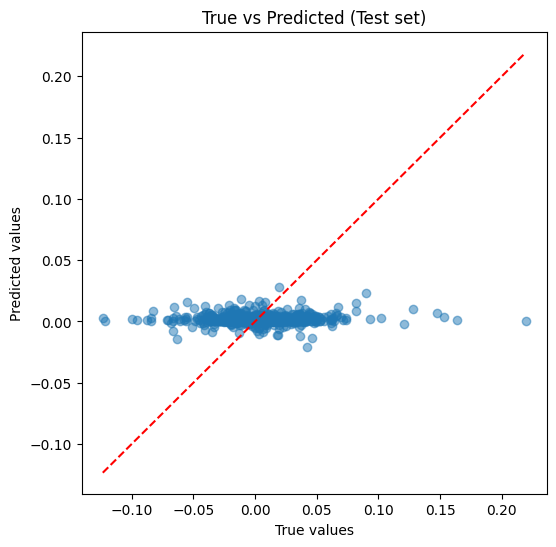

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted (Test set)")
plt.show()


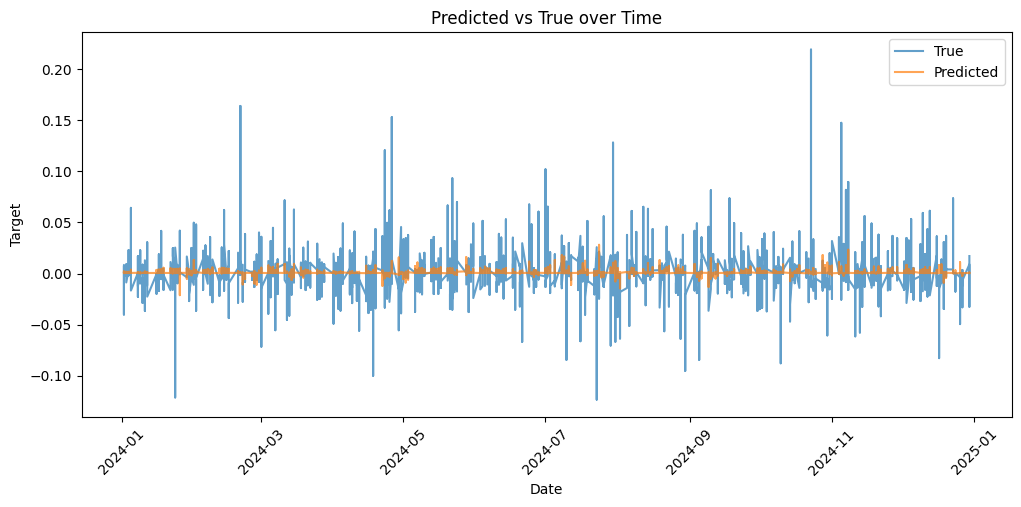

In [103]:
plt.figure(figsize=(12,5))
plt.plot(df_long.loc[test_mask, "Date"].values, y_test, label="True", alpha=0.7)
plt.plot(df_long.loc[test_mask, "Date"].values, y_pred_test, label="Predicted", alpha=0.7)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Target")
plt.title("Predicted vs True over Time")
plt.xticks(rotation=45)
plt.show()


## Observation
Predicted returns are tightly centered around 0 and show limited spread relative to the true series. The model exhibits weak amplitude learning (underconfident), tending to regress toward the mean. Nevertheless, it achieves modest directional/ranking skill (Hit ≈ 0.53, IC ≈ 0.04), indicating some cross-sectional information without reliable magnitude prediction.